<a href="https://colab.research.google.com/github/adhithyasash1/Deep-Generative-Models/blob/main/week_123_dgm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional DC GAN

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Hyperparameters
latent_dim = 100             # Size of input noise vector to generator
num_classes = 10             # MNIST has 10 digit classes
embedding_dim = 50           # Size of label embedding vectors
epochs = 20
batch_size = 128
lr = 0.0002
img_size = 28                # MNIST image size
channels = 1                 # Grayscale
img_shape = (channels, img_size, img_size)

# Data
transform = transforms.Compose([
    transforms.Resize(img_size),                # Just in case
    transforms.ToTensor(),                      # Converts to [C, H, W]
    transforms.Normalize([0.5], [0.5])          # Scale to [-1, 1]
])

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [29]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.init_size = img_size // 4  # Output size after 2 upscales
        self.l1 = nn.Sequential(nn.Linear(latent_dim + embedding_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 → 14
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),  # 14 → 28
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        x = torch.cat((noise, label_input), dim=1)
        x = self.l1(x)
        x = x.view(x.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(x)
        return img

In [30]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.label_proj = nn.Sequential(
            nn.Linear(embedding_dim, img_size * img_size)
        )

        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 3, 2, 1),  # (2, 28, 28) → (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),  # (64, 14, 14) → (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        label_map = self.label_proj(label_input).view(img.size(0), 1, img_size, img_size)
        d_in = torch.cat((img, label_map), dim=1)  # Concatenate channel-wise
        validity = self.model(d_in)
        return validity

In [31]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
opt_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


# Image saving utility
def sample_image(epoch, generator, noise, labels):
    generator.eval()
    with torch.no_grad():
        gen_imgs = generator(noise, labels).detach().cpu()
        gen_imgs = gen_imgs * 0.5 + 0.5  # Denormalize to [0,1]

    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(gen_imgs[i][0], cmap="gray")
        axes[i].set_title(f"Digit: {labels[i].item()}")
        axes[i].axis("off")
    plt.tight_layout()
    os.makedirs("images", exist_ok=True)
    plt.savefig(f"images/cdcgan_epoch_{epoch}.png")
    plt.close()


# Fixed noise and labels for consistent evaluation
fixed_noise = torch.randn(10, latent_dim).to(device)
fixed_labels = torch.arange(0, 10).to(device)

In [32]:
# Training loop
for epoch in range(1, epochs + 1):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        opt_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = criterion(validity, real)
        g_loss.backward()
        opt_G.step()

        # Train Discriminator
        opt_D.zero_grad()
        real_loss = criterion(discriminator(imgs, labels), real)
        fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        opt_D.step()

    print(f"[Epoch {epoch}/{epochs}] D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")
    sample_image(epoch, generator, fixed_noise, fixed_labels)

[Epoch 1/10] D loss: 0.5599 | G loss: 0.9241
[Epoch 2/10] D loss: 0.4916 | G loss: 1.0864
[Epoch 3/10] D loss: 0.5625 | G loss: 1.3506
[Epoch 4/10] D loss: 0.3190 | G loss: 2.2019
[Epoch 5/10] D loss: 0.3693 | G loss: 0.9147
[Epoch 6/10] D loss: 0.3898 | G loss: 1.3725
[Epoch 7/10] D loss: 0.3671 | G loss: 1.2043
[Epoch 8/10] D loss: 0.6103 | G loss: 0.6295
[Epoch 9/10] D loss: 0.3689 | G loss: 1.6296
[Epoch 10/10] D loss: 0.6969 | G loss: 0.7799


# DCGAN with Recent Advances

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
num_classes = 10

In [35]:
class ConditionalBatchNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1.0)  # gamma
        self.embed.weight.data[:, num_features:].zero_()     # beta

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, dim=1)
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
        return gamma * out + beta

In [36]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key   = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        query = self.query(x).view(B, -1, H*W).permute(0, 2, 1)
        key   = self.key(x).view(B, -1, H*W)
        value = self.value(x).view(B, -1, H*W)

        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return self.gamma * out + x

In [37]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, feature_maps, num_classes):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, z_dim)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_maps*4, 4, 1, 0),  # 1x1 -> 4x4
            nn.BatchNorm2d(feature_maps*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps*4, feature_maps*2, 4, 2, 1),  # 4x4 -> 8x8
            nn.BatchNorm2d(feature_maps*2),
            nn.ReLU(True),

            SelfAttention(feature_maps*2),  # 8x8
            nn.ConvTranspose2d(feature_maps*2, feature_maps, 4, 2, 1),  # 8x8 -> 16x16
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps, img_channels, 4, 2, 1),  # 16x16 -> 32x32
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z + self.label_embed(labels)
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)

In [38]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_maps, num_classes, embedding_dim=128):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embedding_dim)

        self.features = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, 4, 2, 1),  # 28 → 14
            nn.LeakyReLU(0.2),
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1),  # 14 → 7
            nn.LeakyReLU(0.2),
            SelfAttention(feature_maps * 2),  # 7x7
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 3, 2, 1),  # 7 → 4
            nn.LeakyReLU(0.2),
        )

        # Dynamically compute the output size after convs
        with torch.no_grad():
            dummy_input = torch.zeros(1, img_channels, 28, 28)
            dummy_output = self.features(dummy_input)
            self.flat_dim = dummy_output.view(1, -1).shape[1]

        self.flatten = nn.Flatten()
        self.real_fake = nn.Linear(self.flat_dim, 1)
        self.embedding_proj = nn.Linear(self.flat_dim, embedding_dim)

    def forward(self, x, labels):
        x = self.features(x)
        x = self.flatten(x)
        out_rf = self.real_fake(x)

        class_embed = self.embed(labels)
        proj = torch.sum(self.embedding_proj(x) * class_embed, dim=1, keepdim=True)

        return out_rf + proj, self.embedding_proj(x)

In [39]:
def contrastive_loss(embeddings, labels, temperature=0.1):
    normed = F.normalize(embeddings, dim=1)
    sim_matrix = torch.matmul(normed, normed.T)
    labels = labels.unsqueeze(1)
    mask = labels == labels.T

    sim_matrix = sim_matrix / temperature
    sim_matrix_exp = torch.exp(sim_matrix)
    sim_matrix_exp = sim_matrix_exp * (~torch.eye(len(labels), dtype=bool, device=labels.device))

    positives = sim_matrix_exp * mask
    negatives = sim_matrix_exp * ~mask

    loss = -torch.log(positives.sum(1) / negatives.sum(1) + 1e-8).mean()
    return loss

In [40]:
G = Generator(z_dim=100, img_channels=1, feature_maps=64, num_classes=10).to(device)
D = Discriminator(img_channels=1, feature_maps=64, num_classes=10).to(device)

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

loss_fn = nn.BCEWithLogitsLoss()
lambda_contrast = 1.0

for epoch in range(5):
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        B = imgs.size(0)
        z = torch.randn(B, 100).to(device)
        fake = G(z, labels)

        # Train Discriminator
        D_real, emb_real = D(imgs, labels)
        D_fake, emb_fake = D(fake.detach(), labels)

        real_loss = loss_fn(D_real, torch.ones_like(D_real))
        fake_loss = loss_fn(D_fake, torch.zeros_like(D_fake))
        contrast_loss = contrastive_loss(emb_real, labels)

        d_loss = real_loss + fake_loss + lambda_contrast * contrast_loss
        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

        # Train Generator
        D_fake, _ = D(fake, labels)
        g_loss = loss_fn(D_fake, torch.ones_like(D_fake))
        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

    print(f"Epoch {epoch}: D Loss {d_loss.item():.3f}, G Loss {g_loss.item():.3f}")

Epoch 0: D Loss -6.041, G Loss 5.036
Epoch 1: D Loss -6.246, G Loss 5.856
Epoch 2: D Loss -6.466, G Loss 7.188
Epoch 3: D Loss -7.053, G Loss 9.577
Epoch 4: D Loss -6.596, G Loss 9.563


In [41]:
def show_generated_images(generator, n_images=16):
    z = torch.randn(n_images, 100).to(device)
    labels = torch.randint(0, 10, (n_images,)).to(device)
    with torch.no_grad():
        samples = generator(z, labels).cpu()
    grid = make_grid(samples, nrow=4, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

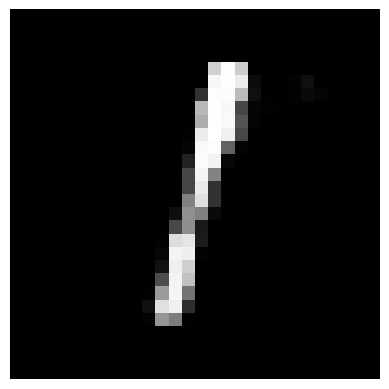

In [68]:
show_generated_images(generator, n_images=1)